In [2]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler

In [3]:
df = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data3/SpotifyFeatures.csv')
df.head()

df2 = pd.read_csv('https://github.com/nkozemaslova/Data_2022/releases/download/data4/spotify_dataset.csv',
                  skiprows=1,
                  names=['user_id', 'artistname', 'trackname', 'playlistname'],
                  on_bad_lines='skip')

# Переименовали колонку "artistname" во втором датасете на "artist_name"
df2 = df2.rename(columns={'artistname': 'artist_name'})

# Переименовали колнку "trackname" во втором датасете на "track_name"
df2 = df2.rename(columns={'trackname': 'track_name'})

#объединенный датасет
data = pd.merge(df, df2, on=['artist_name', 'track_name'], how='inner')
data.shape

(6208202, 20)

In [4]:
data = data[['user_id', 'track_id']].drop_duplicates()
data.shape

(2484403, 2)

In [5]:
data['track_id'].nunique(), len(data['track_id'].value_counts()[data['track_id'].value_counts().values > 25])

(64337, 18770)

In [6]:
data['user_id'].nunique(), len(data['user_id'].value_counts()[data['user_id'].value_counts().values > 50])

(15095, 9600)

In [7]:
print(data.shape)
data = data[data['track_id'].isin(data['track_id'].value_counts()[data['track_id'].value_counts().values > 25].index)]
data = data[data['track_id'].isin(data['track_id'].value_counts()[data['track_id'].value_counts().values > 50].index)]
print(data.shape)

(2484403, 2)
(1913665, 2)


In [8]:
selected_users = pd.DataFrame(data['user_id'].unique()).sample(frac=0.5)[0]
data = data[data['user_id'].isin(selected_users)]
data.shape

(966356, 2)

In [9]:
iteractins = data[['user_id', 'track_id']]
iteractins['rating'] = 1
iteractins.head()

,user_id,track_id,rating
206,76c64f65bd8b0b7627652af1ecceab03,47TqCCnEliDp8NRDyIQoQq,1
207,6d91866c31fb433919bfa93d221fdfc6,47TqCCnEliDp8NRDyIQoQq,1
208,c4397b41b68a636a810517e59f6a476b,47TqCCnEliDp8NRDyIQoQq,1
209,7d7b689e56a53113e9d25f17409773d9,47TqCCnEliDp8NRDyIQoQq,1
210,6700325b89b10e28062641fd077e58ed,47TqCCnEliDp8NRDyIQoQq,1


In [10]:
iteractins_neg = pd.DataFrame(data['user_id'].unique()).merge(pd.DataFrame(data['track_id'].unique()), how='cross').sample(frac=0.15)
iteractins_neg.columns = ['user_id', 'track_id']
iteractins_neg['rating'] = 0
iteractins_neg.head()

,user_id,track_id,rating
60830754,6467d486851524672ebb2a96e7380d40,08xsXR637CEqbxJmpFcuSA,0
45614556,8786741f243b538cbc519dbceb6a2915,43CL49bukqUMNxontuQtR2,0
23416378,949f39decd734acf0542b4d0879f3044,7xqANDRz8JFxkwfY65WISy,0
26651860,a57bdf52925fc4af9630c35380afa67f,36Hwcla06Q5BCr59CL0sBp,0
51362472,3c8d49e91483bed2c696335639ed5439,7EZhegO3ISq6QRWyDWplxc,0


In [11]:
iteractins_ = pd.concat([iteractins_neg, iteractins]).groupby(['user_id', 'track_id']).aggregate({"rating":"max"}).reset_index()
iteractins_.head()

,user_id,track_id,rating
0,000c11a16c89aa4b14b328080f5954ee,001ifh9Zkyc5DhK7AGQRtK,0
1,000c11a16c89aa4b14b328080f5954ee,00QyLmjxaSEE8qIZQjBXBj,0
2,000c11a16c89aa4b14b328080f5954ee,013AWvizllIUEC2FOBzOnh,0
3,000c11a16c89aa4b14b328080f5954ee,01F8B0dhzGdWvmcSO6vUdi,0
4,000c11a16c89aa4b14b328080f5954ee,01TuObJVd7owWchVRuQbQw,0


In [12]:
iteractins_.shape, iteractins_['rating'].mean(), iteractins_['rating'].sum()

((14071767, 3), 0.0686733940378632, 966356)

In [13]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""

    user_groups = ratings.groupby('user_id')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('track_id')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='user_id').
        join(top_movies, rsuffix='_r', how='inner', on='track_id'))

    return pd.crosstab(top.user_id, top.track_id, top.rating, aggfunc=np.sum)

In [14]:
tabular_preview(iteractins_, 15)

track_id,0W4Kpfp1w2xkY3PrV714B7,0n4bITAu0Y0nigrz3MFJMb,1jJci4qxiYcOHhQR247rEU,2dLLR6qlu5UJ5gk0dKz0h3,32OlwWuMpZ6b0aN2RZOeMS,3a2tuvXCHbW5nuUckuHkKT,3bidbhpOYeV4knp8AIu8Xn,3gbBpTdY8lnQwqxNCcf795,3s4U7OHV7gnj42VV72eSZ6,3w3y8KPTfNeOKPiqUTakBh,4G8gkOterJn0Ywt6uhqbhp,4h8VwCb1MTGoLKueQ1WgbD,5FVd6KXrgO9B3JPmC8OPst,5ghIJDpPoe3CfHMGu71E6T,6GmUVqe73u5YRfUUynZK6I
user_id,,,,,,,,,,,,,,,
00dd7fde8040db835d917e077bb47e4b,NaN,NaN,1.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,0.0,1.0,1.0
139c408e52a497aac29753125d65b0ae,1.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
156864cb620f688276d09f126663d7f5,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN
1c43b609f0b4a55de35803000c86ade0,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1d7a6816a47881ad65c4d0fb65b49c41,0.0,1.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN
3196442b472af9bbb51e1628ca3c188a,1.0,NaN,1.0,0.0,NaN,1.0,NaN,0.0,1.0,NaN,0.0,NaN,1.0,1.0,NaN
383413342563cd4c28904f8c202bdfa7,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,0.0,1.0,NaN,1.0,NaN,NaN
6752faf971cd451d87b270621979e2d5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
68756b4d60b6fac27789e85c2b63d1c6,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('user_id')['rating'].count()

    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)

    unique_tracks = ratings.track_id.unique()
    track_to_index = {old: new for new, old in enumerate(unique_tracks)}
    new_track = ratings.track_id.map(track_to_index)

    n_users = unique_users.shape[0]
    n_tracks = unique_tracks.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_track})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_tracks), (X, y), (user_to_index, track_to_index)

In [16]:
(n, m), (X, y), _ = create_dataset(iteractins_)
print(f'Embeddings: {n} users, {m} tracks')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 7430 users, 11889 tracks
Dataset shape: (14071767, 2)
Target shape: (14071767,)


In [17]:
class ReviewsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)

        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]

        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [18]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [19]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[7352, 3107],
        [5579, 4721],
        [3951, 7286],
        [3816, 6292]])
tensor([[0.],
        [0.],
        [0.],
        [0.]])


In [31]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.

    Args:

        n_users:
            Number of unique users in the dataset.

        n_movies:
            Number of unique movies in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applyied right after each of hidden layers.

    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02,
                 dropouts=0.2):

        super().__init__()
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.item_embedding = nn.Embedding(n_movies, n_factors)
        self.fc1 = nn.Linear(in_features=n_factors*2, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)

    def forward(self, users, movies, minmax=None):

        user_embedded = self.user_embedding(users)
        item_embedded = self.item_embedding(movies)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred

def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [32]:
EmbeddingNet(n, m, n_factors=150, dropouts=[0.25, 0.5])

EmbeddingNet(
  (user_embedding): Embedding(7430, 150)
  (item_embedding): Embedding(11889, 150)
  (fc1): Linear(in_features=300, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)

In [33]:
class CyclicLR(_LRScheduler):

    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [34]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):

    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)

        return base_lr + delta

    return scheduler

In [35]:
def cosine(t_max, eta_min=0):

    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2

    return scheduler

In [36]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

In [37]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [38]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [39]:
minmax = float(iteractins_.rating.min()), float(iteractins_.rating.max())
minmax

(0.0, 1.0)

In [41]:
net = EmbeddingNet(
    n_users=n, n_movies=m,
    n_factors=150,
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [42]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/10))

In [43]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False

        running_loss = 0
        n_batches = 0

        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()

            #print(x_batch[:,0])


            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)

                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())

            running_loss += loss.item()

        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss

        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1

    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


loss improvement on epoch: 1
[001/100] train: 0.0555 - val: 0.0532
loss improvement on epoch: 2
[002/100] train: 0.0525 - val: 0.0529
loss improvement on epoch: 3
[003/100] train: 0.0526 - val: 0.0528
loss improvement on epoch: 4
[004/100] train: 0.0518 - val: 0.0526
loss improvement on epoch: 5
[005/100] train: 0.0518 - val: 0.0521
loss improvement on epoch: 6
[006/100] train: 0.0502 - val: 0.0515
loss improvement on epoch: 7
[007/100] train: 0.0495 - val: 0.0499
loss improvement on epoch: 8
[008/100] train: 0.0473 - val: 0.0493
loss improvement on epoch: 9
[009/100] train: 0.0470 - val: 0.0483
loss improvement on epoch: 10
[010/100] train: 0.0449 - val: 0.0480
loss improvement on epoch: 11
[011/100] train: 0.0450 - val: 0.0473
loss improvement on epoch: 12
[012/100] train: 0.0430 - val: 0.0473
loss improvement on epoch: 13
[013/100] train: 0.0434 - val: 0.0469
[014/100] train: 0.0414 - val: 0.0470
loss improvement on epoch: 15
[015/100] train: 0.0420 - val: 0.0467
[016/100] train: 0.

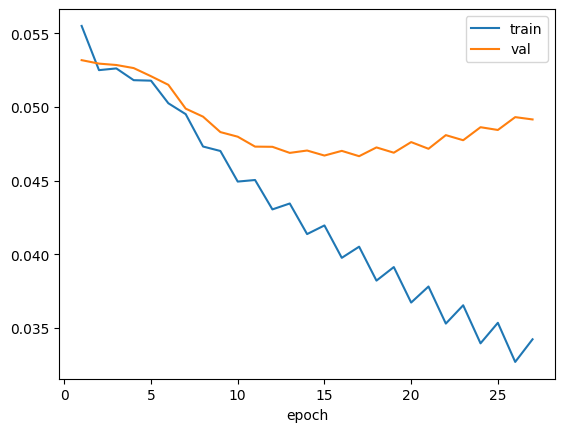

In [44]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

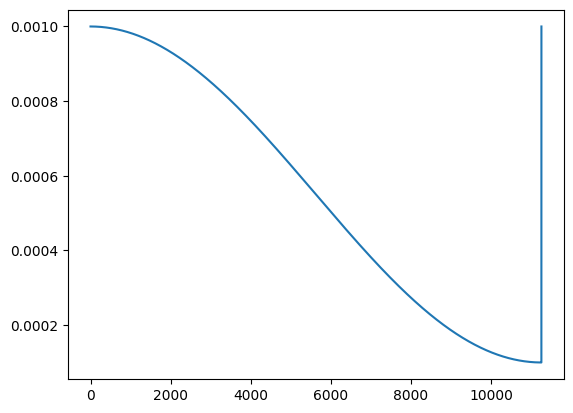

In [45]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])


In [46]:
net.load_state_dict(best_weights)


<All keys matched successfully>

In [47]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [48]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.2160


In [49]:
predictions, len(predictions)

(array([1.37693295e-02, 2.48039636e-04, 1.03275245e-02, ...,
        2.80478783e-02, 4.13894534e-01, 3.91376950e-03]),
 2814000)

In [50]:
result = pd.DataFrame(np.array(groud_truth), columns=["actual"])

In [51]:
result

,actual
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
2813995,0.0
2813996,0.0
2813997,0.0
2813998,0.0


In [52]:
result['predict'] = predictions

In [53]:
result.groupby(['actual']).aggregate({"predict":['mean', 'std']})

predict          
            mean       std
actual                    
0.0     0.041590  0.102931
1.0     0.351888  0.303682

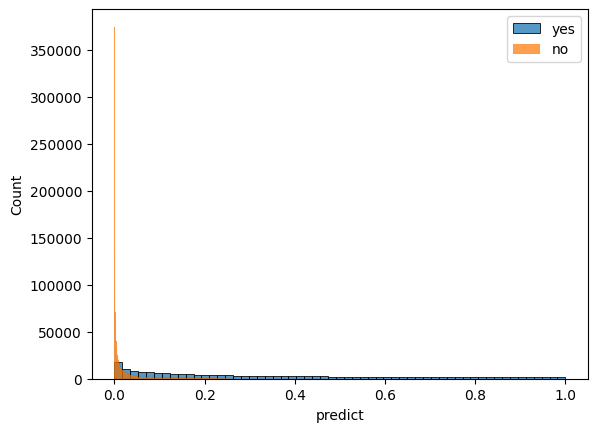

In [54]:
import seaborn as sns
sns.histplot(result[result['actual'] == 1]['predict'], label="yes")
sns.histplot(result[result['actual'] == 0]['predict'], label="no")
plt.legend()